# Feed-forward сети

Итак, давайте потренируемся тренировать нейронные сети прямого распространения (так как делали на паре)
При этом попробуем создать свою функцию активации на одном из слоев

In [2]:
#!python -m ipykernel install --user --name=torchenv
#!jupyter kernelspec uninstall env

Installed kernelspec torchenv in C:\Users\dndav\AppData\Roaming\jupyter\kernels\torchenv


In [47]:
# Сделаем необходимые импорты
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch import optim
import torch.nn.functional as F
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
from tqdm import tqdm

In [42]:
# Загрузим датасет CIFAR-100, сразу же создадим dataloader для него
# Если вам не хватает вычислительных ресурсов, то можно вернуться к CIFAR-10
train_dataset = torchvision.datasets.CIFAR100(root='data/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

Files already downloaded and verified


In [10]:
image, label = train_dataset[0]
print (f'{image.size()=}, {label=}')

image.size()=torch.Size([3, 32, 32]), label=19


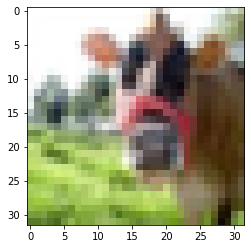

In [36]:
plt.imshow(image.permute(1, 2, 0).numpy())

In [43]:
test_dataset = torchvision.datasets.CIFAR100(root='data./', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

Files already downloaded and verified


In [336]:
# Создайте собственную архитектуру! Можете использовать все, что угодно, но в ограничении на использование линейные слои (пока без сверток)
# Давайте добавим ограниченный Leaky_relu, то есть output = max(0.1x, 0.5x)
# Ваша задача добавить его в архитектуру сети как функцию активации

def leaky_relu_slope(f):
    def wrapper(*args):
        s
        return f(*args)
    return wrapper

class Perceptron(nn.Module):
    
    # tuple с активационными функциями (tuple для неизменности)
    Activatons = namedtuple('Activatons', 'relu silu leaky_relu sigmoid softmax')
    activations = Activatons(F.relu, F.silu, F.leaky_relu, F.sigmoid, F.softmax)
    
    def __init__(self, input_dim, output_dim, activation='relu', activation_params=[]):
        super(Perceptron, self).__init__()
        #fc - полносвязный слой
        self.fc = nn.Linear(input_dim, output_dim)
        #ac - функция активации
        self.ac = getattr(self.activations, activation)
        #ac_params - параметры функции активации
        self.ac_params = activation_params

    def forward(self, x):
        x = self.fc(x)
        return self.ac(x, *self.ac_params)

    
class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Model, self).__init__()
        # модель задана 4-мя слоями перцептронов
        self.layers = nn.ModuleList([
            Perceptron(input_dim, 2*hidden_dim, "leaky_relu", [0.1]),
            Perceptron(2*hidden_dim, 4*hidden_dim, "leaky_relu", [0.5]),
            Perceptron(4*hidden_dim, 2*hidden_dim, "silu"),
            Perceptron(2*hidden_dim, output_dim, "softmax"),
        ])
        
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)

        for layer in self.layers[:-1]:
            x = layer.forward(x)
        return self.layers[-1].fc(x)  
    
    def predict(self, x):
        x = x.view(x.shape[0], -1)
        
        for layer in self.layers:
            x = layer.forward(x) 
        return x


In [337]:
model = Model(3072, 100, 100)

In [338]:
# Запустить обучение (по аналогии с тем, что делали на паре)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [339]:
for epoch in tqdm(range(50)):  
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Training is finished!')

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[1,     1] loss: 0.002
[1,   301] loss: 0.683
[1,   601] loss: 0.623


  2%|█▋                                                                                 | 1/50 [00:27<22:40, 27.76s/it]

[2,     1] loss: 0.002
[2,   301] loss: 0.583
[2,   601] loss: 0.565


  4%|███▎                                                                               | 2/50 [00:53<21:20, 26.69s/it]

[3,     1] loss: 0.002
[3,   301] loss: 0.543
[3,   601] loss: 0.538


  6%|████▉                                                                              | 3/50 [01:21<21:21, 27.28s/it]

[4,     1] loss: 0.002
[4,   301] loss: 0.518
[4,   601] loss: 0.517


  8%|██████▋                                                                            | 4/50 [01:49<21:09, 27.60s/it]

[5,     1] loss: 0.002
[5,   301] loss: 0.504
[5,   601] loss: 0.504


 10%|████████▎                                                                          | 5/50 [02:27<23:20, 31.11s/it]

[6,     1] loss: 0.002
[6,   301] loss: 0.491
[6,   601] loss: 0.490


 12%|█████████▉                                                                         | 6/50 [02:55<22:10, 30.23s/it]

[7,     1] loss: 0.002
[7,   301] loss: 0.479
[7,   601] loss: 0.483


 14%|███████████▌                                                                       | 7/50 [03:22<20:54, 29.17s/it]

[8,     1] loss: 0.002
[8,   301] loss: 0.469
[8,   601] loss: 0.475


 16%|█████████████▎                                                                     | 8/50 [03:49<19:52, 28.39s/it]

[9,     1] loss: 0.002
[9,   301] loss: 0.462
[9,   601] loss: 0.467


 18%|██████████████▉                                                                    | 9/50 [04:16<19:05, 27.95s/it]

[10,     1] loss: 0.002
[10,   301] loss: 0.455
[10,   601] loss: 0.461


 20%|████████████████▍                                                                 | 10/50 [04:44<18:37, 27.93s/it]

[11,     1] loss: 0.002
[11,   301] loss: 0.449
[11,   601] loss: 0.452


 22%|██████████████████                                                                | 11/50 [05:12<18:09, 27.93s/it]

[12,     1] loss: 0.001
[12,   301] loss: 0.443
[12,   601] loss: 0.447


 24%|███████████████████▋                                                              | 12/50 [05:39<17:40, 27.91s/it]

[13,     1] loss: 0.001
[13,   301] loss: 0.436
[13,   601] loss: 0.440


 26%|█████████████████████▎                                                            | 13/50 [06:07<17:09, 27.84s/it]

[14,     1] loss: 0.001
[14,   301] loss: 0.431
[14,   601] loss: 0.434


 28%|██████████████████████▉                                                           | 14/50 [06:34<16:31, 27.55s/it]

[15,     1] loss: 0.001
[15,   301] loss: 0.425
[15,   601] loss: 0.431


 30%|████████████████████████▌                                                         | 15/50 [07:03<16:19, 27.98s/it]

[16,     1] loss: 0.001
[16,   301] loss: 0.419
[16,   601] loss: 0.426


 32%|██████████████████████████▏                                                       | 16/50 [07:35<16:32, 29.18s/it]

[17,     1] loss: 0.001
[17,   301] loss: 0.415
[17,   601] loss: 0.420


 34%|███████████████████████████▉                                                      | 17/50 [08:22<18:57, 34.48s/it]

[18,     1] loss: 0.001
[18,   301] loss: 0.409
[18,   601] loss: 0.416


 36%|█████████████████████████████▌                                                    | 18/50 [08:52<17:38, 33.07s/it]

[19,     1] loss: 0.002
[19,   301] loss: 0.408
[19,   601] loss: 0.409


 38%|███████████████████████████████▏                                                  | 19/50 [09:21<16:30, 31.95s/it]

[20,     1] loss: 0.001
[20,   301] loss: 0.397
[20,   601] loss: 0.409


 40%|████████████████████████████████▊                                                 | 20/50 [09:50<15:33, 31.11s/it]

[21,     1] loss: 0.001
[21,   301] loss: 0.395
[21,   601] loss: 0.402


 42%|██████████████████████████████████▍                                               | 21/50 [10:20<14:48, 30.65s/it]

[22,     1] loss: 0.001
[22,   301] loss: 0.391
[22,   601] loss: 0.399


 44%|████████████████████████████████████                                              | 22/50 [14:22<43:58, 94.24s/it]

[23,     1] loss: 0.001
[23,   301] loss: 0.386
[23,   601] loss: 0.394


 46%|█████████████████████████████████████▋                                            | 23/50 [15:07<35:40, 79.29s/it]

[24,     1] loss: 0.001
[24,   301] loss: 0.384
[24,   601] loss: 0.390


 48%|███████████████████████████████████████▎                                          | 24/50 [15:50<29:45, 68.67s/it]

[25,     1] loss: 0.001
[25,   301] loss: 0.377
[25,   601] loss: 0.388


 50%|█████████████████████████████████████████                                         | 25/50 [16:24<24:15, 58.24s/it]

[26,     1] loss: 0.001
[26,   301] loss: 0.375
[26,   601] loss: 0.384


 52%|██████████████████████████████████████████▋                                       | 26/50 [17:02<20:47, 52.00s/it]

[27,     1] loss: 0.001
[27,   301] loss: 0.369
[27,   601] loss: 0.379


 54%|████████████████████████████████████████████▎                                     | 27/50 [17:44<18:48, 49.05s/it]

[28,     1] loss: 0.001
[28,   301] loss: 0.366
[28,   601] loss: 0.374


 56%|█████████████████████████████████████████████▉                                    | 28/50 [18:21<16:37, 45.35s/it]

[29,     1] loss: 0.001
[29,   301] loss: 0.361
[29,   601] loss: 0.373


 58%|███████████████████████████████████████████████▌                                  | 29/50 [18:58<14:59, 42.84s/it]

[30,     1] loss: 0.001
[30,   301] loss: 0.356
[30,   601] loss: 0.374


 60%|█████████████████████████████████████████████████▏                                | 30/50 [19:41<14:16, 42.84s/it]

[31,     1] loss: 0.001
[31,   301] loss: 0.351
[31,   601] loss: 0.367


 62%|██████████████████████████████████████████████████▊                               | 31/50 [20:21<13:21, 42.21s/it]

[32,     1] loss: 0.001
[32,   301] loss: 0.348
[32,   601] loss: 0.365


 64%|████████████████████████████████████████████████████▍                             | 32/50 [20:56<11:58, 39.91s/it]

[33,     1] loss: 0.001
[33,   301] loss: 0.346
[33,   601] loss: 0.360


 66%|██████████████████████████████████████████████████████                            | 33/50 [21:29<10:42, 37.78s/it]

[34,     1] loss: 0.001
[34,   301] loss: 0.345
[34,   601] loss: 0.354


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [21:57<09:21, 35.07s/it]

[35,     1] loss: 0.001
[35,   301] loss: 0.341
[35,   601] loss: 0.355


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [22:33<08:49, 35.28s/it]

[36,     1] loss: 0.001
[36,   301] loss: 0.340
[36,   601] loss: 0.349


 72%|███████████████████████████████████████████████████████████                       | 36/50 [23:07<08:08, 34.90s/it]

[37,     1] loss: 0.001
[37,   301] loss: 0.331
[37,   601] loss: 0.349


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [23:40<07:24, 34.20s/it]

[38,     1] loss: 0.001
[38,   301] loss: 0.329
[38,   601] loss: 0.344


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [24:12<06:42, 33.56s/it]

[39,     1] loss: 0.001
[39,   301] loss: 0.328
[39,   601] loss: 0.344


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [24:46<06:09, 33.61s/it]

[40,     1] loss: 0.001
[40,   301] loss: 0.322
[40,   601] loss: 0.339


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [25:22<05:45, 34.56s/it]

[41,     1] loss: 0.001
[41,   301] loss: 0.320
[41,   601] loss: 0.338


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [25:50<04:52, 32.52s/it]

[42,     1] loss: 0.001
[42,   301] loss: 0.323
[42,   601] loss: 0.335


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [26:16<04:05, 30.63s/it]

[43,     1] loss: 0.001
[43,   301] loss: 0.317
[43,   601] loss: 0.330


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [26:47<03:34, 30.60s/it]

[44,     1] loss: 0.001
[44,   301] loss: 0.314
[44,   601] loss: 0.329


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [27:21<03:10, 31.81s/it]

[45,     1] loss: 0.001
[45,   301] loss: 0.314
[45,   601] loss: 0.326


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [27:57<02:44, 32.83s/it]

[46,     1] loss: 0.001
[46,   301] loss: 0.306
[46,   601] loss: 0.323


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [28:29<02:10, 32.64s/it]

[47,     1] loss: 0.001
[47,   301] loss: 0.305
[47,   601] loss: 0.320


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [29:02<01:38, 32.83s/it]

[48,     1] loss: 0.001
[48,   301] loss: 0.304
[48,   601] loss: 0.319


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [29:34<01:05, 32.62s/it]

[49,     1] loss: 0.001
[49,   301] loss: 0.297
[49,   601] loss: 0.317


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [30:08<00:32, 32.88s/it]

[50,     1] loss: 0.001
[50,   301] loss: 0.298
[50,   601] loss: 0.315


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [30:44<00:00, 36.88s/it]

Training is finished!
